# Coral bleaching alert

To get coral bleaching data at your prefered latitude and longitude, go to http://oos.soest.hawaii.edu/thredds/ncss/hioos/satellite/dhw_5km/dataset.html and enter the coordinated (note that it can't be a single point) and click submit. It will probably take several minutes to compute and will be saved to you downloads file.

In [1]:
# Load required modules.
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as stats
from datetime import date, timedelta
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

## Enter the path where you saved the data here:

In [2]:
# Only use forward slashes!
data_path = 'C:/Users/astel/Documents/GitHub/scix_mhws/data/'

## Enter your selected latitude and longitude here:

In [3]:
lat = -16.125
lon = 146.625

Load the MHW .csv files

In [4]:
mhws = pd.read_csv(data_path + 'event_lon_{}_lat_{}.csv'.format(lon, lat), parse_dates=[3, 4, 5, 6])
mhws.head()

,lon,lat,event_no,date_start,date_peak,date_end,duration,intensity_mean,intensity_max,intensity_cumulative
0,146.625,-16.125,1,1982-03-08,1982-03-13,1982-03-16,9,1.437,1.73,12.93
1,146.625,-16.125,2,1983-06-05,1983-06-12,1983-06-16,12,1.044,1.20,12.53
2,146.625,-16.125,3,1983-10-15,1983-10-17,1983-10-19,5,1.596,2.13,7.98
3,146.625,-16.125,4,1983-11-09,1983-11-10,1983-11-13,5,1.676,1.96,8.38
4,146.625,-16.125,5,1984-01-31,1984-02-03,1984-02-07,8,1.105,1.22,8.84


### Convert mhw pandas data to xarray:

In [5]:
# Creating a new pandas dataframe where the first column is now 'date_start'.
mhw = mhws.reset_index(level=0, drop=True)
mhw = mhws.set_index('date_start')
mhw.head()

# Converting to xarray.
mhw = mhws.to_xarray()
mhw['duration'] = mhw.duration.astype(dtype=int) # For some reason the duration wasn't loaded as numbers, so fixing that.

# Changing the coordinate to date_start (keeping the name 'index')
# This way, all MHWs are sorted into the year that they started (similar to Oliver at al. 2018)
mhw['index'] = mhw.date_start
# mhw['index'] = pd.to_datetime(mhw['index'], errors='coerce') # fixes a random error.

print(mhw)

<xarray.Dataset>
Dimensions:               (index: 88)
Coordinates:
  * index                 (index) datetime64[ns] 1982-03-08 ... 2018-12-21
Data variables:
    lon                   (index) float64 146.6 146.6 146.6 ... 146.6 146.6
    lat                   (index) float64 -16.12 -16.12 -16.12 ... -16.12 -16.12
    event_no              (index) int64 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88
    date_start            (index) datetime64[ns] 1982-03-08 ... 2018-12-21
    date_peak             (index) datetime64[ns] 1982-03-13 ... 2018-12-21
    date_end              (index) datetime64[ns] 1982-03-16 ... 2018-12-29
    duration              (index) int32 9 12 5 5 8 9 6 13 ... 8 14 5 25 6 7 7 9
    intensity_mean        (index) float64 1.437 1.044 1.596 ... 0.983 1.621
    intensity_max         (index) float64 1.73 1.2 2.13 1.96 ... 1.51 1.07 1.79
    intensity_cumulative  (index) float64 12.93 12.53 7.98 ... 9.36 6.88 14.59


### Convert MHW data to annual 

In [6]:
mhw = mhw.resample(index='Y').mean()
mhw

<xarray.Dataset>
Dimensions:               (index: 37)
Coordinates:
  * index                 (index) datetime64[ns] 1982-12-31 ... 2018-12-31
Data variables:
    lon                   (index) float64 146.6 146.6 146.6 ... 146.6 146.6
    lat                   (index) float64 -16.12 -16.12 -16.12 ... -16.12 -16.12
    event_no              (index) float64 1.0 3.0 5.0 nan ... 78.5 84.0 87.5
    duration              (index) float64 9.0 7.333 8.0 nan ... 22.83 11.4 8.0
    intensity_mean        (index) float64 1.437 1.439 1.105 ... 1.261 1.302
    intensity_max         (index) float64 1.73 1.763 1.22 ... 1.96 1.528 1.43
    intensity_cumulative  (index) float64 12.93 9.63 8.84 ... 31.66 15.41 10.73

# Load the NOAA coral reef watch data.

Note that this file contains timeseries of coral alert data at a number of different lat/lons over the great barrier reef.

In [7]:
# http://oos.soest.hawaii.edu/thredds/ncss/hioos/satellite/dhw_5km/dataset.html
ds = xr.open_dataset(data_path + 'NOAA_coral_alert_gbr.nc')
ds

<xarray.Dataset>
Dimensions:       (latitude: 251, longitude: 181, time: 12696)
Coordinates:
  * latitude      (latitude) float32 -12.524996 -12.574999 ... -25.024996
  * longitude     (longitude) float32 144.975 145.025 ... 153.92499 153.975
  * time          (time) datetime64[ns] 1985-03-25T12:00:00 ... 2019-12-31T12:00:00
Data variables:
    surface_flag  (latitude, longitude) int8 ...
    CRW_BAA       (time, latitude, longitude) float32 ...
Attributes:
    acknowledgement:                 NOAA Coral Reef Watch
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Coral Reef Watch Operational Daily ...
    summary:                         Contains a suite of NOAA Coral Reef Watc...
    references:                      http://coralreefwatch.noaa.gov/satellite/
    institution:                     National Oceanic and Atmospheric Adminis...
    comment:                         This is a product of the NOAA Coral Reef...
    license:          

In [8]:
# Select your lat/lon (or don't to get the average over the area) and use groupby to find the annual sum.
# Note that the latitude and longitude must be exactly the same as in the file (use ds.longitude to check, etc).
ds = ds.sel(latitude=-16.524996, longitude=146.525).groupby('time.year').sum()
ds

<xarray.Dataset>
Dimensions:       (year: 35)
Coordinates:
    latitude      float32 -16.524996
    longitude     float32 146.525
  * year          (year) int64 1985 1986 1987 1988 1989 ... 2016 2017 2018 2019
Data variables:
    surface_flag  (year) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    CRW_BAA       (year) float32 27.0 51.0 118.0 32.0 ... 183.0 185.0 88.0 35.0

In [9]:
# We only have bleaching data from 1985 to 2020 (wheras we have MHW data from 1982 to 2020).
# So we will slice the MHW data to match.
mhw = mhw.sel(index=slice('1984-12-31', '2020-12-31'))
mhw

<xarray.Dataset>
Dimensions:               (index: 35)
Coordinates:
  * index                 (index) datetime64[ns] 1984-12-31 ... 2018-12-31
Data variables:
    lon                   (index) float64 146.6 nan nan ... 146.6 146.6 146.6
    lat                   (index) float64 -16.12 nan nan ... -16.12 -16.12
    event_no              (index) float64 5.0 nan nan 6.0 ... 78.5 84.0 87.5
    duration              (index) float64 8.0 nan nan 9.0 ... 9.5 22.83 11.4 8.0
    intensity_mean        (index) float64 1.105 nan nan ... 1.405 1.261 1.302
    intensity_max         (index) float64 1.22 nan nan 1.59 ... 1.96 1.528 1.43
    intensity_cumulative  (index) float64 8.84 nan nan ... 31.66 15.41 10.73

# Scatter plot of MHW duration as a function of coral bleaching

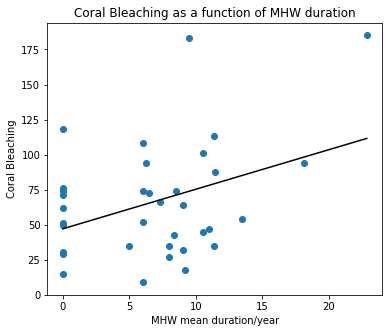

In [11]:
plt.figure(figsize=(6, 5))
plt.title('Coral Bleaching as a function of MHW duration')

# Using .fillna(0) because not all years had a MHW and these years were filled with NaN
# fillna(0) will replace NaN values with zero.
plt.scatter(mhw.duration.fillna(0), ds.CRW_BAA)
plt.plot(np.unique(mhw.duration.fillna(0)), 
         np.poly1d(np.polyfit(mhw.duration.fillna(0), ds.CRW_BAA, 1))(np.unique(mhw.duration.fillna(0))), color='k')
plt.xlabel('MHW mean duration/year')
plt.ylabel('Coral Bleaching')
plt.savefig('coral_MHW_duration.png')

# Pearson R correlation test 

In [12]:
print(stats.pearsonr(mhw.duration.fillna(0), ds.CRW_BAA) )

(0.38165045164731, 0.02368064605026926)
